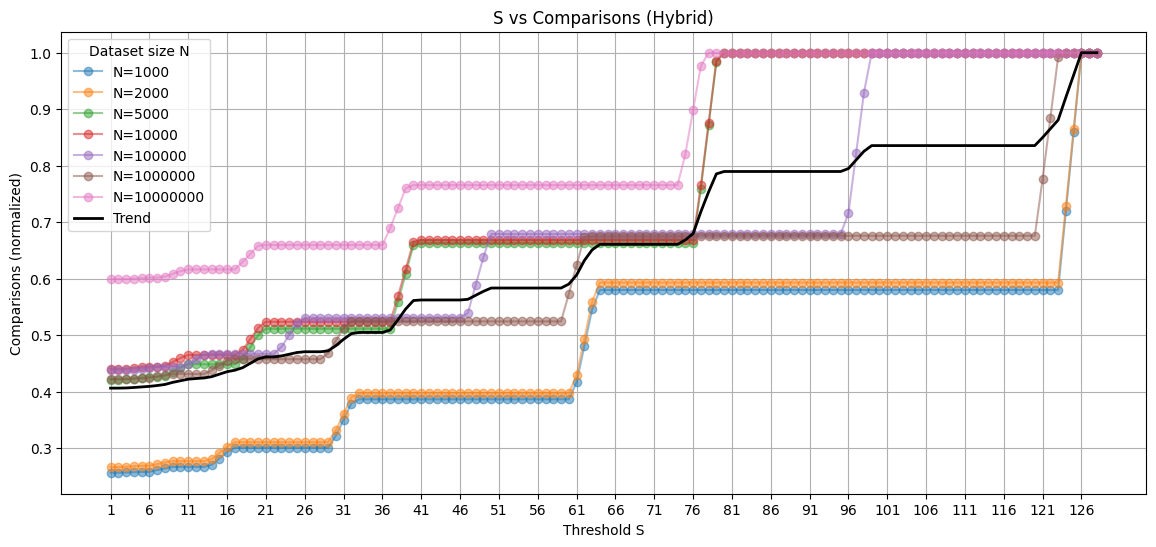

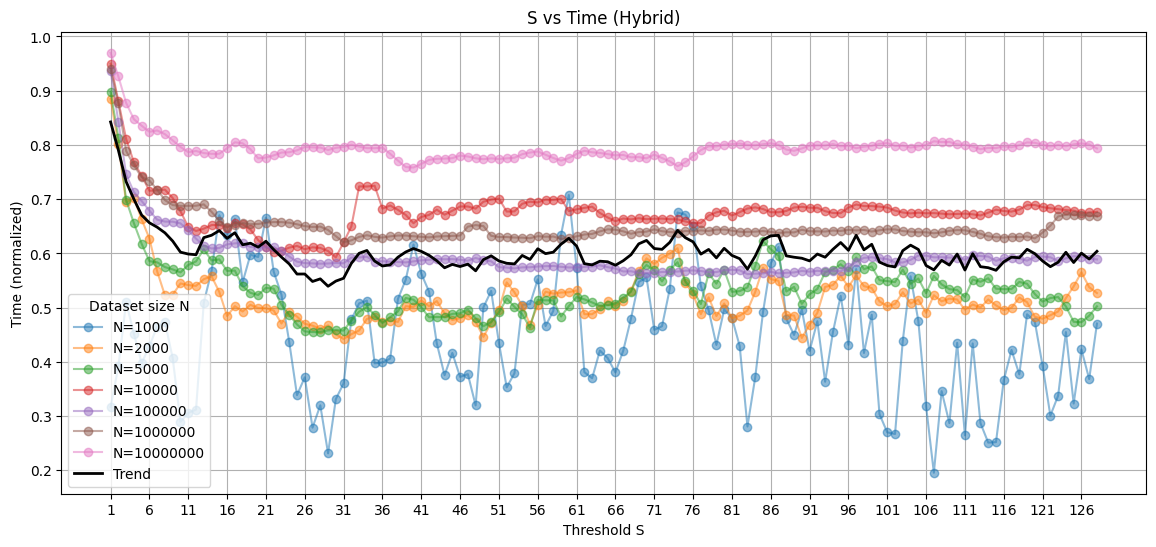

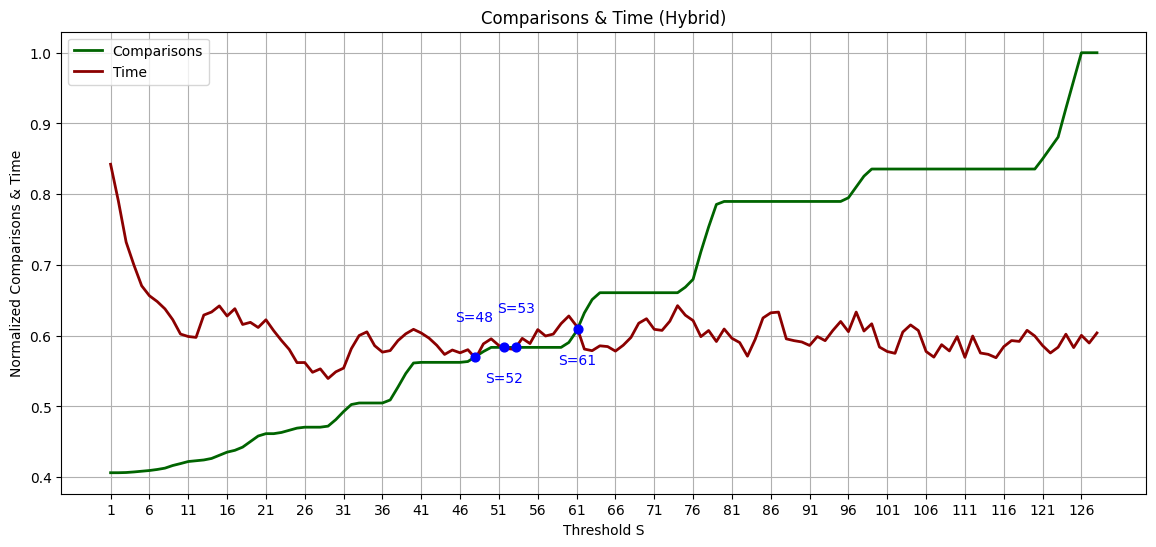

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Load CSV
df = pd.read_csv("hybrid_sort_results.csv")  # Columns: N, S, Comparisons, Time

Ns = sorted(df['N'].unique())
Ss = sorted(df['S'].unique())

# --- Normalize and smooth ---
def normalize_and_smooth(values, window=3):
    scaled = values / np.max(values)
    smooth = uniform_filter1d(scaled, size=window)
    return smooth

# Prepare trend storage
comp_trends = []
time_trends = []

# --- Plot 1: S vs Comparisons ---
plt.figure(figsize=(14,6))
for N in Ns:
    subset = df[df['N'] == N].sort_values('S')
    smooth_comp = normalize_and_smooth(subset['Comparisons'].values)
    comp_trends.append(smooth_comp)
    plt.plot(Ss, smooth_comp, alpha=0.5, label=f'N={N}', marker='o')

comp_trends = np.array(comp_trends)
comp_trend = np.mean(comp_trends, axis=0)
plt.plot(Ss, comp_trend, color='black', linewidth=2, label='Trend')

plt.xlabel('Threshold S')
plt.ylabel('Comparisons (normalized)')
plt.title('S vs Comparisons (Hybrid)')
plt.xticks(Ss[::5])
plt.legend(title='Dataset size N')
plt.grid(True)
plt.show()

# --- Plot 2: S vs Time ---
plt.figure(figsize=(14,6))
for N in Ns:
    subset = df[df['N'] == N].sort_values('S')
    smooth_time = normalize_and_smooth(subset['Time'].values)
    time_trends.append(smooth_time)
    plt.plot(Ss, smooth_time, alpha=0.5, label=f'N={N}', marker='o')

time_trends = np.array(time_trends)
time_trend = np.mean(time_trends, axis=0)
plt.plot(Ss, time_trend, color='black', linewidth=2, label='Trend')

plt.xlabel('Threshold S')
plt.ylabel('Time (normalized)')
plt.title('S vs Time (Hybrid)')
plt.xticks(Ss[::5])
plt.legend(title='Dataset size N')
plt.grid(True)
plt.show()

# --- Plot 3: Overlay with intersection points ---
# Assume comp_trend and time_trend are already computed from previous steps
# Ss = sorted S values

plt.figure(figsize=(14,6))

# Plot trends
plt.plot(Ss, comp_trend, color='darkgreen', linewidth=2, label='Comparisons')
plt.plot(Ss, time_trend, color='darkred', linewidth=2, label='Time')

# Find intersections
diff = comp_trend - time_trend
sign_changes = np.where(np.diff(np.sign(diff)))[0]

# Filter out consecutive indices to avoid repeated labels
filtered_indices = []
for idx in sign_changes:
    if len(filtered_indices) == 0 or idx - filtered_indices[-1] > 1:
        filtered_indices.append(idx)

# Plot intersection points and annotate
label_offsets = [0.05, -0.05]  # alternate label offsets
dot_size = 40  # smaller dots

for i, idx in enumerate(filtered_indices):
    x0, x1 = Ss[idx], Ss[idx+1]
    y0_c, y1_c = comp_trend[idx], comp_trend[idx+1]
    y0_t, y1_t = time_trend[idx], time_trend[idx+1]

    # Linear interpolation to approximate intersection
    slope_c = (y1_c - y0_c)/(x1 - x0)
    slope_t = (y1_t - y0_t)/(x1 - x0)
    S_intersect = x0 + (y0_t - y0_c)/(slope_c - slope_t)
    y_intersect = y0_c + slope_c*(S_intersect - x0)

    plt.scatter(S_intersect, y_intersect, color='blue', s=dot_size, zorder=5)
    offset = label_offsets[i % len(label_offsets)]
    plt.text(S_intersect, y_intersect + offset, f'S={S_intersect:.0f}', ha='center', color='blue')

# Axis labels, title, ticks
plt.xlabel('Threshold S')
plt.ylabel('Normalized Comparisons & Time')
plt.title('Comparisons & Time (Hybrid)')
plt.xticks(Ss[::5])  # every 5th S
plt.grid(True)
plt.legend()
plt.show()

